# EYE FOR BLIND

Apurv Dube

A project for generating an audio description of images. This kind of model has potential applications for blind people so that they can understand any image with the help of speech descritions.

It is comprised of a deeplearning model based on encoder-decoder architecture with attention mechanism. This project is based on an extension of the paper, "Show, Attend and Tell: Neural Image Caption Generation with Visual Attention".

Given that we need to generte a text caption, this model involves both image understanding and NLP. The features of an image will be extracted by a CNN-based encoder and this will be decoded by an RNN model. The caption generated through a CNN-RNN model will be converted to speech using a text to speech library.

The Flicr8K dataset is used for training this model. The dataset is taken from the Kaggle website and it consists of sentence-based image descriptions having a list of 8,000 images that are each paired with five different captions which provide clear descriptions of the salient entities and events of the image.


In [ ]:
#Import all the required libraries

!pip install gTTs
!pip install playsound

import os
import glob 
import matplotlib.pyplot as plt #for plotting graphs
from skimage import io
import pandas as pd
import numpy as np
import collections, random, re
from collections import Counter
import tensorflow as tf
from keras.preprocessing.image import load_img
from keras.preprocessing.text import Tokenizer
import operator
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tqdm import tqdm
from tensorflow.keras import layers, Model
import time
from PIL import Image
from gtts import gTTS
from playsound import playsound
from IPython import display
from nltk.translate.bleu_score import sentence_bleu


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for playsound: filename=playsound-1.3.0-py3-none-any.whl size=7035 sha256=a564f78f54d0546c938b26ffbc9733e99ebdcf8d2a75698629bd1e05232f66d0
  Stored in directory: /root/.cache/pip/wheels/ba/f8/bb/ea57c0146b664dca3a0ada4199b0ecb5f9dfcb7b7e22b65ba2
Successfully built playsound


In [ ]:
# Set your working directory to a folder in your Google Drive. This way, if your notebook times out,
# your files will be saved in your Google Drive!

## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

# the base Google Drive directory
root_dir = "/content/gdrive/MyDrive/"

# choose where you want your project files to be saved
project_folder = "Colab Notebooks/Eye_for_blind_Project--Apurv/"

def create_and_set_working_directory(project_folder):
  # check if your project folder exists. if not, it will be created.
  if os.path.isdir(root_dir + project_folder) == False:
    os.mkdir(root_dir + project_folder)
    print(root_dir + project_folder + ' did not exist but was created.')

  # change the OS to use your project folder as the working directory
  os.chdir(root_dir + project_folder)

  # create a test file to make sure it shows up in the right place
  !touch 'new_file_in_working_directory.txt'
  print('\nYour working directory was changed to ' + root_dir + project_folder + \
        "\n\nAn empty text file was created there. You can also run !pwd to confirm the current working directory." )

create_and_set_working_directory(project_folder)

Mounted at /content/gdrive

Your working directory was changed to /content/gdrive/MyDrive/Colab Notebooks/Eye_for_blind_Project--Apurv/

An empty text file was created there. You can also run !pwd to confirm the current working directory.


Let's read the dataset

## Data understanding
1.Import the dataset and read image & captions into two seperate variables

2.Visualise both the images & text present in the dataset

3.Create a dataframe which summarizes the image, path & captions as a dataframe

4.Create a list which contains all the captions & path

5.Visualise the top 30 occuring words in the captions



In [ ]:
#Import the dataset and read the image into a separate variable

images='data/Images/'

all_imgs = glob.glob(images + '/*.jpg',recursive=True)
print("The total images present in the dataset: {}".format(len(all_imgs)))

The total images present in the dataset: 8091


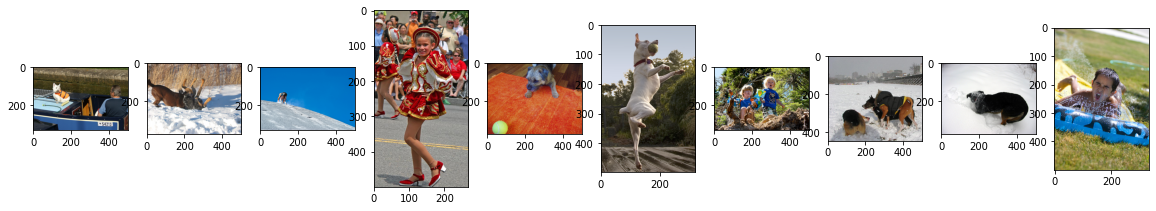

In [ ]:
#Visualise both the images & text present in the dataset

Display_Images= all_imgs[0:10]
figure, axes = plt.subplots(1,10)
figure.set_figwidth(20)
   
for ax,image in zip(axes, Display_Images):
    ax.imshow(io.imread(image), cmap=None)

(375, 500, 3)
[63 28 26]
[0.24705882 0.10980392 0.10196078]


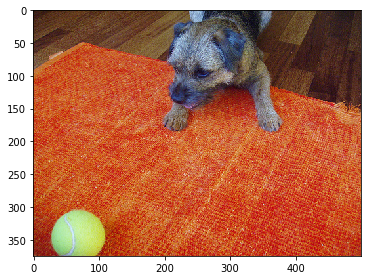

In [ ]:
# Checking image details before we begin normalizing them

myimg = io.imread(all_imgs[4])
print(myimg.shape)
print(myimg[10, 10, :])
#myimg[10:50, 10:50, :] = [200, 100, 100]
#myimg[myimg < 128] = 0
myimg = (myimg/255)
print(myimg[10, 10, :])
io.imshow(myimg)
io.show()

In [ ]:
#Import the dataset and read the text file into a separate variable

text_file ='data/captions.txt'


def load_doc(filename):
    
    #your code here
    open_file = open(text_file, 'r', encoding="latin-1") 
    text = open_file.read() 
    open_file.close()    
        
    return text

doc = load_doc(text_file)
# Printing the first 860 characters of the captions file.
print(doc[:860])

image,caption
1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg,A girl going into a wooden building .
1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playhouse .
1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a wooden cabin .
1001773457_577c3a7d70.jpg,A black dog and a spotted dog are fighting
1001773457_577c3a7d70.jpg,A black dog and a tri-colored dog playing with each other on the road .
1001773457_577c3a7d70.jpg,A black dog and a white dog with brown spots are staring at each other in the street .
1001773457_577c3a7d70.jpg,Two dogs of different breeds looking at each other on the road .
1001773457_577c3a7d70.jpg,Two dogs on pavement moving toward each other .



Create a dataframe which summarizes the image, path & captions as a dataframe

Each image id has 5 captions associated with it therefore the total dataset should have 40455 samples.

In [ ]:
img_cap = doc.split('\n')
img_cap.pop(0)## poping first line names of columns (image,caption)



all_img_id= [] #store all the image id here
all_img_vector= [] #store all the image path here
annotations= [] #store all the captions here

for line in img_cap:
    col = line.split(',')# Seperates columns image and caption
   
    if len(col)==1:
        continue
    image = col[0].split("_") # seperating image filename to extract the id 
   
    image[1] = images + col[0] # saving complete path of image file for building model
    
    all_img_id.append(image[0])
    all_img_vector.append(image[1])
    annotations.append(col[1].lower())


df = pd.DataFrame(list(zip(all_img_id, all_img_vector,annotations)),columns =['ID','Path', 'Captions']) 
df['Captions'] = df['Captions'].str.strip('.')    
unique_images= np.unique(df.ID.values)
print("The number of unique images : {}".format(len(unique_images)))
print("The number of captions for each image:",Counter(Counter(df.ID.values).values()))


The number of unique images : 8091
The number of captions for each image: Counter({5: 8091})


In [ ]:
pd.set_option('display.max_colwidth', None)  
df.head(10)

,ID,Path,Captions
0,1000268201,data/Images/1000268201_693b08cb0e.jpg,a child in a pink dress is climbing up a set of stairs in an entry way
1,1000268201,data/Images/1000268201_693b08cb0e.jpg,a girl going into a wooden building
2,1000268201,data/Images/1000268201_693b08cb0e.jpg,a little girl climbing into a wooden playhouse
3,1000268201,data/Images/1000268201_693b08cb0e.jpg,a little girl climbing the stairs to her playhouse
4,1000268201,data/Images/1000268201_693b08cb0e.jpg,a little girl in a pink dress going into a wooden cabin
5,1001773457,data/Images/1001773457_577c3a7d70.jpg,a black dog and a spotted dog are fighting
6,1001773457,data/Images/1001773457_577c3a7d70.jpg,a black dog and a tri-colored dog playing with each other on the road
7,1001773457,data/Images/1001773457_577c3a7d70.jpg,a black dog and a white dog with brown spots are staring at each other in the street
8,1001773457,data/Images/1001773457_577c3a7d70.jpg,two dogs of different breeds looking at each other on the road
9,1001773457,data/Images/1001773457_577c3a7d70.jpg,two dogs on pavement moving toward each other


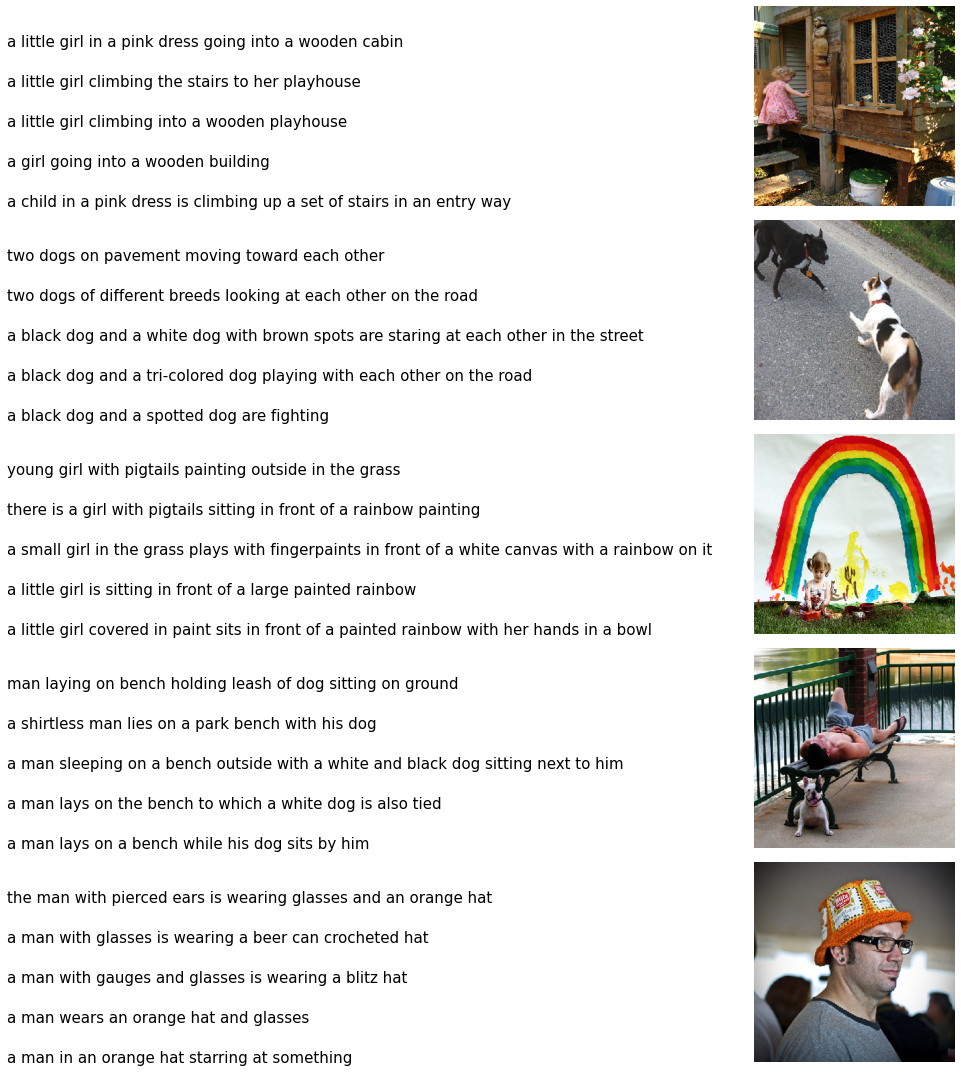

In [ ]:
# Printing all captions for a few sample images

fig = plt.figure(figsize=(15,15)) # For dosplaying image
count = 1
    
for Path in df[:25].Path.unique(): # Loading 1st 25 paths which will have 5 distinct images
    captions = list(df["Captions"].loc[df.Path== Path].values)
    display_image = load_img(Path,target_size=(299,299,3))
    ax = fig.add_subplot(5,2,count) #Adding a subplot that spans 5 rows:
    plt.axis('off')  # we don't want both x and y axes for caption 
    ax.plot()
    ax.set_xlim(0,1)
    ax.set_ylim(0,len(captions)) #to decide the spacing between each line of caption
    for i, caption in enumerate(captions):
        ax.text(0,i,caption,fontsize=15)  #to display the captions         
    count+=1
    plt.tight_layout() #to make sure that image and caption don't overlap

    ax = fig.add_subplot(5,2,count)
    ax.imshow(display_image)
    plt.axis('off')
    count +=1

plt.show()


In [ ]:
#Create a list which contains all the captions

#add the <start> & <end> token to all those captions as well
#write your code here

img_id= df.ID #store all the image id 
img_vector= df.Path #store all the image path here
captions = df.Captions #store all the captions here

annotations = df.Captions.apply(lambda x : f"<start> {x} <end>")

#Create a list which contains all the path to the images
img_path= sorted(set(img_vector))

print("Total captions present in the dataset: "+ str(len(captions)))
print("Total images present in the dataset: " + str(len(img_path)))

Total captions present in the dataset: 40455
Total images present in the dataset: 8091


In [ ]:
#Create the vocabulary & the counter for the captions

vocabulary = []
for cap in captions.values:
        vocabulary.extend(cap.split())

val_count=Counter(vocabulary)
print(f"Size of Vocab : {len(set(vocabulary))}")
print(f"Top Words in Vocab : {val_count.most_common(30)}")

Size of Vocab : 8871
Top Words in Vocab : [('a', 60196), ('in', 18174), ('the', 17507), ('on', 10357), ('is', 9069), ('and', 8057), ('dog', 7948), ('with', 7304), ('man', 7137), ('of', 6495), ('two', 5132), ('white', 3706), ('black', 3620), ('boy', 3514), ('are', 3365), ('woman', 3304), ('girl', 3277), ('to', 3005), ('wearing', 2916), ('people', 2811), ('at', 2810), ('water', 2676), ('young', 2587), ('red', 2553), ('brown', 2457), ('an', 2325), ('his', 2255), ('blue', 2125), ('dogs', 2095), ('running', 1996)]


In [ ]:
#Visualise the top 30 occuring words in the captions

top_words30 = val_count.most_common(30)

df_top_words30 = pd.DataFrame(top_words30, columns = ['Word', 'Count'])

df_top_words30.head(30)



,Word,Count
0,a,60196
1,in,18174
2,the,17507
3,on,10357
4,is,9069
5,and,8057
6,dog,7948
7,with,7304
8,man,7137
9,of,6495


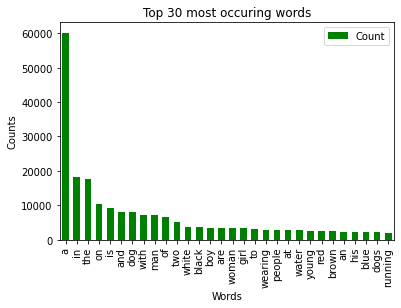

In [ ]:
df_top_words30.plot.bar(x='Word',y='Count',width=0.6,color='green')
plt.title("Top 30 most occuring words")
plt.xlabel("Words")
plt.ylabel("Counts")
plt.show()

## Pre-Processing the captions
1.Create the tokenized vectors by tokenizing the captions fore ex :split them using spaces & other filters. 
This gives us a vocabulary of all of the unique words in the data. Keep the total vocaublary to top 5,000 words for saving memory.

2.Replace all other words with the unknown token "UNK" .

3.Create word-to-index and index-to-word mappings.

4.Pad all sequences to be the same length as the longest one.

In [ ]:
# create the tokenizer

top_freq_words = 5000
special_chars = '!"#$%&()*+.,-/:;=?@[\]^_`{|}~ '
tokenizer = Tokenizer(num_words= top_freq_words,oov_token="UNK",filters=special_chars)

In [ ]:
# Create word-to-index and index-to-word mappings.

tokenizer.fit_on_texts(annotations) #Updates internal vocabulary based on a list of texts.

# Assign indices to the following tokens

tokenizer.word_index['PAD'] = 0
tokenizer.index_word[0] = 'PAD'


train_seqs = tokenizer.texts_to_sequences(annotations) #Transforms each text in texts to a sequence of integers.


def print_word_to_index(word):
    print("Word = {}, index = {}".format(word, tokenizer.word_index[word]))
def print_index_to_word(index):
    print("Index = {}, Word = {}".format(index, tokenizer.index_word[index]))

print_index_to_word(0)
print_index_to_word(1)
print_index_to_word(3)
print_index_to_word(4)
print(train_seqs[:5])
print(annotations[:5])



Index = 0, Word = PAD
Index = 1, Word = UNK
Index = 3, Word = <start>
Index = 4, Word = <end>
[[3, 2, 44, 5, 2, 89, 173, 8, 116, 52, 2, 389, 13, 385, 5, 29, 1, 670, 4], [3, 2, 20, 313, 64, 2, 197, 120, 4], [3, 2, 39, 20, 116, 64, 2, 197, 2368, 4], [3, 2, 39, 20, 116, 6, 385, 21, 63, 2368, 4], [3, 2, 39, 20, 5, 2, 89, 173, 313, 64, 2, 197, 2887, 4]]
0    <start> a child in a pink dress is climbing up a set of stairs in an entry way  <end>
1                                       <start> a girl going into a wooden building  <end>
2                            <start> a little girl climbing into a wooden playhouse  <end>
3                        <start> a little girl climbing the stairs to her playhouse  <end>
4                   <start> a little girl in a pink dress going into a wooden cabin  <end>
Name: Captions, dtype: object


In [ ]:
# Create a word count of your tokenizer to visulize the Top 30 occuring words after text processing

word_count = tokenizer.word_counts
word_count = sorted(word_count.items(), key=operator.itemgetter(1),reverse=True)

df_top30w0rds = pd.DataFrame(word_count[:30], columns = ['Word', 'Count'])
df_top30w0rds.head(30)


,Word,Count
0,a,61436
1,<start>,40455
2,<end>,40455
3,in,18193
4,the,17677
5,on,10369
6,is,9069
7,and,8066
8,dog,7958
9,with,7308


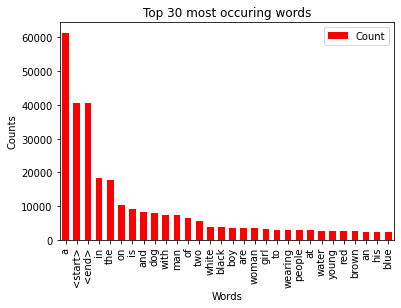

In [ ]:
df_top30w0rds.plot.bar(x='Word',y='Count',width=0.6,color='red')
plt.title("Top 30 most occuring words")
plt.xlabel("Words")
plt.ylabel("Counts")
plt.show()


In [ ]:
# Maximum length of sequence 
max_length = 0
max_length = max([len(train) for train in train_seqs])
print(max_length)

35


In [ ]:
# Pad each vector to the max_length of the captions and store it to a vairable

cap_vector= tf.keras.preprocessing.sequence.pad_sequences(train_seqs, maxlen = 35, dtype = 'int32',padding='post')
print("The shape of Caption vector is :" + str(cap_vector.shape))
print(cap_vector[:5])

The shape of Caption vector is :(40455, 35)
[[   3    2   44    5    2   89  173    8  116   52    2  389   13  385
     5   29    1  670    4    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0]
 [   3    2   20  313   64    2  197  120    4    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0]
 [   3    2   39   20  116   64    2  197 2368    4    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0]
 [   3    2   39   20  116    6  385   21   63 2368    4    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0]
 [   3    2   39   20    5    2   89  173  313   64    2  197 2887    4
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0]]


## Pre-processing the images

1.Resize them into the shape of (299, 299)

3.Normalize the image within the range of -1 to 1, such that it is in correct format for InceptionV3. 

### FAQs on how to resize the images::
* Since you have a list which contains all the image path, you need to first convert them to a dataset using <i>tf.data.Dataset.from_tensor_slices</i>. Once you have created a dataset consisting of image paths, you need to apply a function to the dataset which will apply the necessary preprocessing to each image. 
* This function should resize them and also should do the necessary preprocessing that it is in correct format for InceptionV3.


In [ ]:
#write your code here to create the dataset consisting of image paths

image_path= df.Path.values
print(image_path[:5])

['data/Images/1000268201_693b08cb0e.jpg'
 'data/Images/1000268201_693b08cb0e.jpg'
 'data/Images/1000268201_693b08cb0e.jpg'
 'data/Images/1000268201_693b08cb0e.jpg'
 'data/Images/1000268201_693b08cb0e.jpg']


In [ ]:
#write your code here for creating the function. This function should return images & their path

def preprocess_image(image_path):
    img = tf.io.read_file(image_path,name=None)
    # by default channels=0 which indictaes to use the number of channels in the JPEG-encoded image.
    #Since its RGB images,we can give channels=3 also which will output an RGB image.
    img = tf.image.decode_jpeg(img,channels=3) 
    IMAGE_SHAPE = 299,299
    img = tf.image.resize(img, IMAGE_SHAPE)
    img = tf.keras.applications.inception_v3.preprocess_input(img,data_format=None) #Default value for data format is None
    # It refers to global setting tf.keras.backend.image_data_format()
    return img, image_path
       

In [ ]:
#write your code here for applying the function to the image path dataset, such that the transformed dataset should contain images & their path

# We tried various different sizes and noticed that batch sizes of 32 and 128 led to worse performance.
BATCH_SIZE = 64
unique_image_vector = sorted (set(all_img_vector))
image_dataset = tf.data.Dataset.from_tensor_slices(unique_image_vector)
image_dataset = image_dataset.map(preprocess_image, num_parallel_calls = tf.data.experimental.AUTOTUNE)
image_dataset = image_dataset.batch(BATCH_SIZE,drop_remainder=False)


## Load the pretrained Imagenet weights of Inception net V3

1.To save the memory(RAM) from getting exhausted, extract the features of the images using the last layer of pre-trained model. Including this as part of training will lead to higher computational time.

2.The shape of the output of this layer is 8x8x2048. 

3.Use a function to extract the features of each image in the train & test dataset such that the shape of each image should be (batch_size, 8*8, 2048)



In [ ]:
image_model = tf.keras.applications.InceptionV3(include_top=False,weights='imagenet')

#write code here to get the input of the image_model
new_input = image_model.input 
#write code here to get the output of the image_model
hidden_layer = image_model.layers[-1].output 
#build the final model using both input & output layer
image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

87924736/87910968 [==============================] - 1s 0us/step


In [ ]:
image_features_extract_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, None, None,   864         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 batch_normalization (BatchNorm  (None, None, None,   96         ['conv2d[0][0]']                 
 alization)                     32)                                                           

In [ ]:
# write the code to apply the feature_extraction model to your earlier created dataset which contained images & their respective paths
# Once the features are created, you need to reshape them such that feature shape is in order of (batch_size, 8*8, 2048)

# write your code to extract features from each image in the dataset
image_features_dict={}
for image, image_path in tqdm(image_dataset): 
    features_for_batch = image_features_extract_model(image) #feeding images from above created dataset to Inception v3 which we build above
    features_for_batch_flattened = tf.reshape(features_for_batch,
                             (features_for_batch.shape[0], -1, features_for_batch.shape[3])) ##We are sqeezing/squashing 
                                   
    for batch_feat, path in zip(features_for_batch_flattened, image_path):
        feature_path = path.numpy().decode("utf-8")
        image_features_dict[feature_path] =  batch_feat.numpy()



100%|██████████| 127/127 [03:22<00:00,  1.59s/it]


### FAQs on how to store the features:
* You can store the features using a dictionary with the path as the key and values as the feature extracted by the inception net v3 model OR
* You can store using numpy(np.save) to store the resulting vector.

## Dataset creation
1.Apply train_test_split on both image path & captions to create the train & test list. Create the train-test spliit using 80-20 ratio & random state = 42

2.Create a function which maps the image path to their feature. 

3.Create a builder function to create train & test dataset & apply the function created earlier to transform the dataset

2.Make sure you have done Shuffle and batch while building the dataset

3.The shape of each image in the dataset after building should be (batch_size, 8*8, 2048)

4.The shape of each caption in the dataset after building should be(batch_size, max_len)


In [ ]:
#write your code here
# Splitting the train and test sets
path_train, path_test, cap_train, cap_test = train_test_split(all_img_vector,cap_vector, test_size=0.2, random_state=42)

In [ ]:
print("Training data for images: " + str(len(path_train)))
print("Testing data for images: " + str(len(path_test)))
print("Training data for Captions: " + str(len(cap_train)))
print("Testing data for Captions: " + str(len(cap_test)))

Training data for images: 32364
Testing data for images: 8091
Training data for Captions: 32364
Testing data for Captions: 8091


In [ ]:
# Create a function which maps the image path to their feature. 
# This function will take the image_path & caption and return it's feature & respective caption.

def map_func(image_path, caption):
  feature = image_features_dict[image_path.decode('utf-8')]
  return (feature,caption)

### FAQs on how to load the features:
* You can load the features using the dictionary created earlier OR
* You can store using numpy(np.load) to load the feature vector.

In [ ]:
# create a builder function to create dataset which takes in the image path & captions as input
# This function should transform the created dataset(img_path,cap) to (features,cap) using the map_func created earlier

# Buffer size to shuffle the dataset
# (TF data is designed to work with possibly infinite sequences,
# so it doesn't attempt to shuffle the entire sequence in memory. Instead,
# it maintains a buffer in which it shuffles elements).
BUFFER_SIZE = 1000

def gen_dataset(images_data, captions_data):
    
    # Creating a Dataset using tf.data.Dataset.from_tensor_slice 
    dataset = tf.data.Dataset.from_tensor_slices((images_data, captions_data))

    # num_parallel_calls= tf.data.AUTOTUNE is used, then the number of parallel calls is set dynamically based on available CPU.
    dataset = dataset.map(lambda item1, item2: tf.numpy_function(map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE)
    
    # reshuffle_each_iteration=True indicate Shuffle order should be different for each epoch.
    # Keeping batch_size=64 (64 consecutive elements of this dataset is combined in a single batch).
    # We don't want to drop the last batch if it contains element less than 64.So let's set drop_remainder=False 
    # Prefetch function is used to prepare later elements while the current element is being processed.
    
    dataset = (
     dataset.shuffle(BUFFER_SIZE, reshuffle_each_iteration=True) 
    .batch(BATCH_SIZE, drop_remainder=False)
    .prefetch(tf.data.experimental.AUTOTUNE)
    ) 

    return dataset



In [ ]:
train_dataset = gen_dataset(path_train,cap_train)
test_dataset = gen_dataset(path_test,cap_test)

In [ ]:
sample_img_batch, sample_cap_batch = next(iter(train_dataset))
print(sample_img_batch.shape)  #(batch_size, 8*8, 2048)
print(sample_cap_batch.shape) #(batch_size,max_len)

(64, 64, 2048)
(64, 35)


## Model Building
1.Set the parameters

2.Build the Encoder, Attention model & Decoder

In [ ]:
# Various values for the different hyperparameters were tried and the results are listed in the conclusions at the end.
# Embedding dimensions 128 and 256 were also tried, but we found better results for 512.
# We have tried using 256 and 1024 units as well and the results were worse than that with 512 units.

embedding_dim = 512
units = 512
vocab_size = 5001 #top 5,000 words +1
train_num_steps = len(path_train) // BATCH_SIZE
test_num_steps = len(path_test) // BATCH_SIZE
max_length=35
features_shape = batch_feat.shape[1]
attention_features_shape = batch_feat.shape[0]
print(features_shape)
print(attention_features_shape)

2048
64


### Encoder

In [ ]:
class Encoder(Model):
    def __init__(self,embed_dim):
        super(Encoder, self).__init__()
        self.dense = tf.keras.layers.Dense(embed_dim, activation = 'relu') #build your Dense layer with relu activation
        
    def call(self, features):
        features = self.dense(features)  # extract the features from the image shape: (batch, 8*8, embed_dim)
        
        return features

In [ ]:
encoder = Encoder(embedding_dim)

### Attention model

In [ ]:
class Attention_model(Model):
    def __init__(self, units):
        super(Attention_model, self).__init__()
        self.W1 = tf.keras.layers.Dense(units) #build your Dense layer
        self.W2 = tf.keras.layers.Dense(units) #build your Dense layer
        self.V = tf.keras.layers.Dense(1) #build your final Dense layer with unit 1
        self.units = units

    def call(self, features, hidden):
        #features shape: (batch_size, 8*8, embedding_dim)
        # hidden shape: (batch_size, hidden_size)
        hidden_with_time_axis = tf.expand_dims(hidden,1) # Expand the hidden shape to shape: (batch_size, 1, hidden_size)
        attention_hidden_layer = (tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis)))
        score = self.V(attention_hidden_layer)# build your score funciton to shape: (batch_size, 8*8, units)
        attention_weights =  tf.nn.softmax(score,axis=1)# extract your attention weights with shape: (batch_size, 8*8, 1)
        context_vector = attention_weights * features  #shape: create the context vector with shape (batch_size, 8*8,embedding_dim)
        context_vector = tf.reduce_sum(context_vector,axis=1)# reduce the shape to (batch_size, embedding_dim)
        

        return context_vector, attention_weights

### Decoder

In [ ]:
class Decoder(Model):
    def __init__(self, embed_dim, units, vocab_size):
        super(Decoder, self).__init__()
        self.units=units
        self.attention = Attention_model(self.units)#iniitalise your Attention model with units
        self.embed = tf.keras.layers.Embedding(vocab_size,embed_dim) #build your Embedding layer
        self.gru = tf.keras.layers.GRU(self.units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        self.d1 = tf.keras.layers.Dense(self.units)#build your Dense layer
        self.d2 = tf.keras.layers.Dense(vocab_size)#build your Dense layer
        

    def call(self,x,features, hidden):
        context_vector, attention_weights = self.attention(features,hidden)#create your context vector & attention weights from attention model
        # embed your input to shape: (batch_size, 1, embedding_dim)
        embed =  self.embed(x)
        embed =  tf.concat([tf.expand_dims(context_vector,1),embed],axis=-1)# Concatenate your input with the context vector from attention layer. Shape: (batch_size, 1, embedding_dim + embedding_dim)
        output,state = self.gru(embed)# Extract the output & hidden state from GRU layer. Output shape : (batch_size, max_length, hidden_size)
        output = self.d1(output)
        output = tf.reshape(output, (-1, output.shape[2])) # shape : (batch_size * max_length, hidden_size)
        output = self.d2(output) # shape : (batch_size * max_length, vocab_size)
        
        
        return output,state, attention_weights
    
    def init_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [ ]:
decoder = Decoder(embedding_dim, units, vocab_size)

In [ ]:
features = encoder(sample_img_batch)
print('Feature shape from Encoder: {}'.format(features.shape)) #(batch, 8*8, embed_dim)

hidden = decoder.init_state(batch_size=sample_cap_batch.shape[0])

dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * sample_cap_batch.shape[0], 1)

predictions, hidden_out, attention_weights= decoder(dec_input, features, hidden)
#print('Feature shape from Encoder: {}'.format(features.shape)) #(batch, 8*8, embed_dim)
print('Predcitions shape from Decoder: {}'.format(predictions.shape)) #(batch,vocab_size)
print('Attention weights shape from Decoder: {}'.format(attention_weights.shape)) #(batch, 8*8, embed_dim)

Feature shape from Encoder: (64, 64, 512)
Predcitions shape from Decoder: (64, 5001)
Attention weights shape from Decoder: (64, 64, 1)


## Model training & optimization
1.Set the optimizer & loss object

2.Create your checkpoint path

3.Create your training & testing step functions

4.Create your loss function for the test dataset

In [ ]:
# Learning rate of 0.0005 and 0.002 were tried and they led to worse results
optimizer = tf.keras.optimizers.Adam(lr=0.001)#define the optimizer
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True,
                                                            reduction=tf.keras.losses.Reduction.NONE)  #define your loss object

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [ ]:
checkpoint_path = "/checkpoint/"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [ ]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])

* While creating the training step for your model, you will apply Teacher forcing.
* Teacher forcing is a technique where the target/real word is passed as the next input to the decoder instead of previous prediciton.

In [ ]:
@tf.function
def train_step(img_tensor, target):
    loss = 0
    hidden = decoder.init_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
    
    with tf.GradientTape() as tape:#Record operations for automatic differentiation for implementing backpropagation
        #write your code here to do the training steps
        features = encoder(img_tensor)

        # Using the teacher forcing technique where the target word is passed as the next input to the decoder
        for t in range(1, target.shape[1]):
          # passing encoder_output to the decoder
          predictions, hidden, _ = decoder(dec_input, features, hidden)

          loss += loss_function(target[:, t], predictions)

          dec_input = tf.expand_dims(target[:, t], 1)
    
    avg_loss = (loss / int(target.shape[1])) #we are calculating average loss for every batch

    tot_trainables_variables = encoder.trainable_variables + decoder.trainable_variables
    
    grads = tape.gradient(loss, tot_trainables_variables) # to calculate gradients with respect to every trainable variable

    #compute gradients and apply it to the optimizer and backpropagate.
    optimizer.apply_gradients(zip(grads, tot_trainables_variables)) 
        #write your code here to do the training steps
        
    return loss, avg_loss

* While creating the test step for your model, you will pass your previous prediciton as the next input to the decoder.

In [ ]:
@tf.function
def test_step(img_tensor, target):
    loss = 0
    
    #write your code here to do the testing steps
        
    hidden = decoder.init_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
    features = encoder(img_tensor)
    for i in range(1, target.shape[1]):
          # passing the features through the decoder
            predictions, hidden, _ = decoder(dec_input, features, hidden)

            loss += loss_function(target[:, i], predictions)
            predicted_id = tf.argmax(predictions,1)
            dec_input = tf.expand_dims(predicted_id, 1)
   
    avg_loss = (loss / int(target.shape[1]))
        
    return loss, avg_loss
    
    return loss, avg_loss

In [ ]:
def test_loss_cal(test_dataset):
    total_loss = 0

    #write your code to get the average loss result on your test data
    
    for (batch,(img_tensor,target)) in enumerate(test_dataset):
        batch_loss, t_loss = test_step(img_tensor, target)
        total_loss += t_loss
   
    return total_loss/test_num_steps

In [ ]:
loss_plot = []
test_loss_plot = []

# We have tried using 30 and 50 epochs. The training loss decreases with number of epochs but the test loss keeps increasing. Results with 30 epochs showed no improvement and got worse with 50 epochs.
EPOCHS = 15

best_test_loss=100
for epoch in tqdm(range(0, EPOCHS)):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(train_dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss
        avg_train_loss=total_loss / train_num_steps
        
    loss_plot.append(avg_train_loss)    
    test_loss = test_loss_cal(test_dataset)
    test_loss_plot.append(test_loss)
    
    print ('For epoch: {}, the train loss is {:.3f}, & test loss is {:.3f}'.format(epoch+1,avg_train_loss,test_loss))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))
    
    if test_loss < best_test_loss:
        print('Test loss has been reduced from %.3f to %.3f' % (best_test_loss, test_loss))
        best_test_loss = test_loss
        ckpt_manager.save()

  0%|          | 0/15 [00:00<?, ?it/s]

For epoch: 1, the train loss is 1.335, & test loss is 2.013
Time taken for 1 epoch 177.3943009376526 sec

Test loss has been reduced from 100.000 to 2.013


 13%|█▎        | 2/15 [04:21<26:31, 122.42s/it]

For epoch: 2, the train loss is 1.035, & test loss is 2.062
Time taken for 1 epoch 83.62517666816711 sec



 20%|██        | 3/15 [05:44<20:54, 104.58s/it]

For epoch: 3, the train loss is 0.935, & test loss is 2.034
Time taken for 1 epoch 83.33545637130737 sec



 27%|██▋       | 4/15 [07:08<17:38, 96.23s/it] 

For epoch: 4, the train loss is 0.863, & test loss is 2.031
Time taken for 1 epoch 83.44161033630371 sec



 33%|███▎      | 5/15 [08:31<15:16, 91.67s/it]

For epoch: 5, the train loss is 0.801, & test loss is 2.078
Time taken for 1 epoch 83.56962847709656 sec



 40%|████      | 6/15 [09:55<13:19, 88.81s/it]

For epoch: 6, the train loss is 0.745, & test loss is 2.135
Time taken for 1 epoch 83.2432792186737 sec



 47%|████▋     | 7/15 [11:18<11:37, 87.17s/it]

For epoch: 7, the train loss is 0.695, & test loss is 2.202
Time taken for 1 epoch 83.80385971069336 sec



 53%|█████▎    | 8/15 [12:42<10:01, 85.96s/it]

For epoch: 8, the train loss is 0.646, & test loss is 2.225
Time taken for 1 epoch 83.36732840538025 sec



 60%|██████    | 9/15 [14:05<08:30, 85.17s/it]

For epoch: 9, the train loss is 0.601, & test loss is 2.321
Time taken for 1 epoch 83.41047692298889 sec



 67%|██████▋   | 10/15 [15:29<07:03, 84.71s/it]

For epoch: 10, the train loss is 0.560, & test loss is 2.420
Time taken for 1 epoch 83.70007705688477 sec



 73%|███████▎  | 11/15 [16:52<05:37, 84.33s/it]

For epoch: 11, the train loss is 0.522, & test loss is 2.478
Time taken for 1 epoch 83.43653535842896 sec



 80%|████████  | 12/15 [18:16<04:12, 84.01s/it]

For epoch: 12, the train loss is 0.486, & test loss is 2.553
Time taken for 1 epoch 83.2766661643982 sec



 87%|████████▋ | 13/15 [19:39<02:47, 83.86s/it]

For epoch: 13, the train loss is 0.454, & test loss is 2.707
Time taken for 1 epoch 83.50300312042236 sec



 93%|█████████▎| 14/15 [21:02<01:23, 83.67s/it]

For epoch: 14, the train loss is 0.427, & test loss is 2.785
Time taken for 1 epoch 83.2382583618164 sec



100%|██████████| 15/15 [22:26<00:00, 89.77s/it]

For epoch: 15, the train loss is 0.397, & test loss is 2.908
Time taken for 1 epoch 83.63948583602905 sec



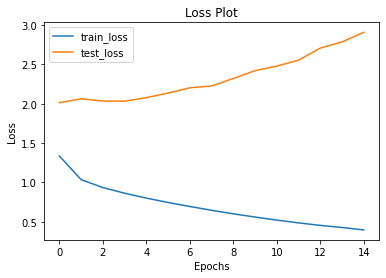

In [ ]:
plt.plot(loss_plot)
plt.plot(test_loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.legend(["train_loss", "test_loss"], loc ="best")
plt.show()

#### NOTE: 
* Since there is a difference between the train & test steps ( Presence of teacher forcing), you may observe that the train loss is decreasing while your test loss is not. 
* This doesn't mean that the model is overfitting, as we can't compare the train & test results here, as both approach is different.
* Also, if you want to achieve better results you can run it more epochs, but the intent of this capstone is to give you an idea on how to integrate attention mechanism with E-D architecture for images. The intent is not to create the state of art model. 

## Model Evaluation
1.Define your evaluation function using greedy search

2.Define your evaluation function using beam search ( optional)

3.Test it on a sample data using BLEU score

### Greedy Search

In [ ]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    #hidden = decoder.reset_state(batch_size=1)
    hidden = decoder.init_state(batch_size=1)

    temp_input = tf.expand_dims(preprocess_image(image)[0], 0) #process the input image to desired format before extracting features
    img_tensor_val = image_features_extract_model(temp_input) # Extract features using our feature extraction model
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)# extract the features by passing the input to encoder

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)# get the output from decoder

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id =  tf.argmax(predictions[0]).numpy()#extract the predicted id(embedded value) which carries the max value
        result.append(tokenizer.index_word[predicted_id])#map the id to the word from tokenizer and append the value to the result list

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot,predictions

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot,predictions



### Beam Search(optional)

In [ ]:
# def beam_evaluate(image, beam_index = #your value for beam index):

#     #write your code to evaluate the result using beam search
                  
#     return final_caption

In [ ]:
def plot_attmap(caption, weights, image):

    fig = plt.figure(figsize=(10, 10))
    temp_img = np.array(Image.open(image))
    
    len_cap = len(caption)
    for cap in range(len_cap):
        weights_img = np.reshape(weights[cap], (8,8))
        weights_img = np.array(Image.fromarray(weights_img).resize((224, 224), Image.LANCZOS))
        
        ax = fig.add_subplot(len_cap//2, len_cap//2, cap+1)
        ax.set_title(caption[cap], fontsize=15)
        
        img=ax.imshow(temp_img)
        
        ax.imshow(weights_img, cmap='gist_heat', alpha=0.6,extent=img.get_extent())
        ax.axis('off')
    plt.subplots_adjust(hspace=0.2, wspace=0.2)
    plt.show()

In [ ]:
def filt_text(text):
    filt=['<start>','<unk>','<end>'] 
    temp= text.split()
    [temp.remove(j) for k in filt for j in temp if k==j]
    text=' '.join(temp)
    return text


BELU scores: 
Cumulative 1-gram: 0.250000
Cumulative 2-gram: 0.000000
Cumulative 3-gram: 0.000000
Cumulative 4-gram: 0.000000
Real Caption: an adult couple pose by a cardboard cut out for a movie
Prediction Caption: a couple in a suit and black standing next to a photo



/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg

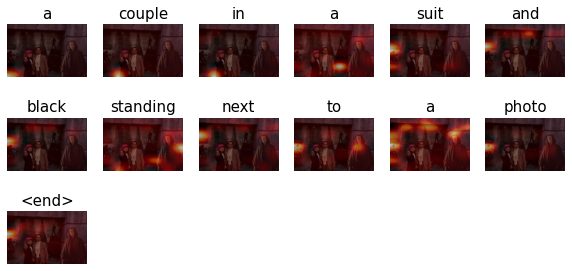

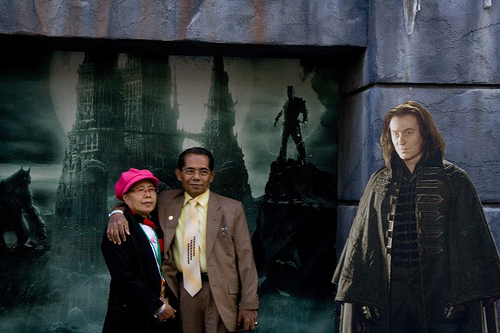

In [ ]:
rid = np.random.randint(0, len(path_test))
test_image = path_test[rid]

#test_image = './images/413231421_43833a11f5.jpg'
#real_caption = '<start> black dog is digging in the snow <end>'

real_caption = ' '.join([tokenizer.index_word[i] for i in cap_test[rid] if i not in [0]])
result, attention_plot,pred_test = evaluate(test_image)

real_caption=filt_text(real_caption)      

pred_caption=' '.join(result).rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = pred_caption.split()

print("\nBLEU scores: ")
print('Cumulative 1-gram: %f' % sentence_bleu(reference, candidate, weights=(1, 0, 0, 0)))
print('Cumulative 2-gram: %f' % sentence_bleu(reference, candidate, weights=(0.5, 0.5, 0, 0)))
print('Cumulative 3-gram: %f' % sentence_bleu(reference, candidate, weights=(0.33, 0.33, 0.33, 0)))
print('Cumulative 4-gram: %f' % sentence_bleu(reference, candidate, weights=(0.25, 0.25, 0.25, 0.25)))

print('Real Caption:', real_caption)

print('Prediction Caption:', pred_caption)
print()
plot_attmap(result, attention_plot, test_image)

#Google Text to Speech Online API for playing the predicted caption as audio
speech = gTTS(""+ pred_caption,lang = 'en', slow = False) 
speech.save('voice.mp3')
audio_file = 'voice.mp3'
    
display.display(display.Audio(audio_file, rate=None,autoplay= False))
    
Image.open(test_image)


BELU scores: 
Cumulative 1-gram: 0.307692
Cumulative 2-gram: 0.160128
Cumulative 3-gram: 0.000000
Cumulative 4-gram: 0.000000
Real Caption: the woman is walking on a UNK narrow bridge
Prediction Caption: a person with black striped t shirt is walking across the cold water



/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


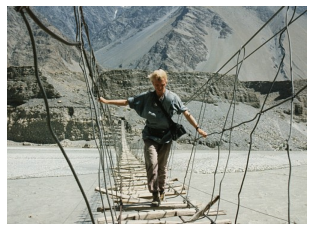


BELU scores: 
Cumulative 1-gram: 0.493781
Cumulative 2-gram: 0.275673
Cumulative 3-gram: 0.000000
Cumulative 4-gram: 0.000000
Real Caption: a boy with swimming trunks and goggles jumping on the sand by the beach
Prediction Caption: a boy in swim trunks jumping in the air at the beach



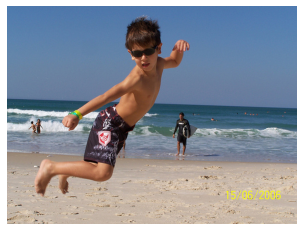


BELU scores: 
Cumulative 1-gram: 0.454545
Cumulative 2-gram: 0.301511
Cumulative 3-gram: 0.000000
Cumulative 4-gram: 0.000000
Real Caption: a boy is standing in the ocean with his arms outstretched
Prediction Caption: a boy wearing a blue shorts is falling into the ocean



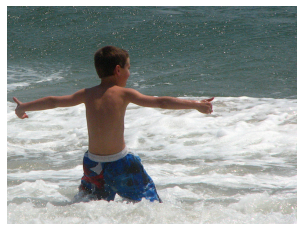


BELU scores: 
Cumulative 1-gram: 0.106931
Cumulative 2-gram: 0.000000
Cumulative 3-gram: 0.000000
Cumulative 4-gram: 0.000000
Real Caption: with a barn in the background a child puts her head through a hole in a cow cutout and smiles for the camera
Prediction Caption: a young girl is sitting by a cut out of a cut out



/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


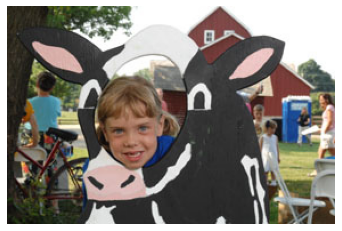


BELU scores: 
Cumulative 1-gram: 0.444444
Cumulative 2-gram: 0.333333
Cumulative 3-gram: 0.000000
Cumulative 4-gram: 0.000000
Real Caption: two girls play in the beach
Prediction Caption: two girls in swimsuits are standing in the water



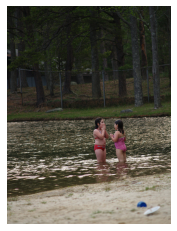

In [ ]:
# Here we select a fixed set of 5 images for comparing the quality of captions generated by different models
ridlist = [101, 201, 301, 401, 501]

for rid in ridlist:
  test_image = path_test[rid]
  #test_image = './images/413231421_43833a11f5.jpg'
  #real_caption = '<start> black dog is digging in the snow <end>'
  
  real_caption = ' '.join([tokenizer.index_word[i] for i in cap_test[rid] if i not in [0]])
  result, attention_plot,pred_test = evaluate(test_image)
  real_caption=filt_text(real_caption)
  pred_caption=' '.join(result).rsplit(' ', 1)[0]
  real_appn = []
  real_appn.append(real_caption.split())
  reference = real_appn
  candidate = pred_caption.split()

  print("\nBLEU scores: ")
  print('Cumulative 1-gram: %f' % sentence_bleu(reference, candidate, weights=(1, 0, 0, 0)))
  print('Cumulative 2-gram: %f' % sentence_bleu(reference, candidate, weights=(0.5, 0.5, 0, 0)))
  print('Cumulative 3-gram: %f' % sentence_bleu(reference, candidate, weights=(0.33, 0.33, 0.33, 0)))
  print('Cumulative 4-gram: %f' % sentence_bleu(reference, candidate, weights=(0.25, 0.25, 0.25, 0.25)))

  print('Real Caption:', real_caption)

  print('Prediction Caption:', pred_caption)
  print()
  #plot_attmap(result, attention_plot, test_image)
  im = Image.open(test_image)
  #im = load_img(Path,target_size=(npix,npix,3))
  plt.axis('off')
  plt.imshow(im)
  plt.show()

In [ ]:
# def init_features(image):
#     temp_input = tf.expand_dims(preprocess_image(image)[0], 0) #process the input image to desired format before extracting features
#     img_tensor_val = image_features_extract_model(temp_input)# Extract features using our feature extraction model
#     img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

#     features = encoder(img_tensor_val)# extract the features by passing the input to encoder

#     dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
#     return features,dec_input

In [ ]:
# #rid = np.random.randint(0, len(path_test))
# rid =1000
# test_image = path_test[rid]
# print(test_image)

# real_caption = ' '.join([tokenizer.index_word[i] for i in cap_test[rid] if i not in [0]])
# real_caption=filt_text(real_caption)
# captions = beam_evaluate(test_image)
# print('Real Caption: '+ real_caption)
# print()
# print('Predicted Caption: ' + captions)
# print()
    
# real_appn = []
# real_appn.append(real_caption.split())
# reference = real_appn
# candidate = captions.split()


# print("\nBLEU scores: ")
# print('Cumulative 1-gram: %f' % sentence_bleu(reference, candidate, weights=(1, 0, 0, 0)))
# print('Cumulative 2-gram: %f' % sentence_bleu(reference, candidate, weights=(0.5, 0.5, 0, 0)))
# print('Cumulative 3-gram: %f' % sentence_bleu(reference, candidate, weights=(0.33, 0.33, 0.33, 0)))
# print('Cumulative 4-gram: %f' % sentence_bleu(reference, candidate, weights=(0.25, 0.25, 0.25, 0.25)))

# #Google Text to Speech Online API for playing the predicted caption as audio
# speech = gTTS(""+ pred_caption,lang = 'en', slow = False) 
# speech.save('voice.mp3')
# audio_file = 'voice.mp3'

# display.display(display.Audio(audio_file, rate=None,autoplay= False))

# Image.open(test_image)

# Conclusion and observations

*  The model was built and tested with different hyperparameters.
*  Sufficiently good results were obtained for certain sets of hyperparameters.
*  The performance was judged based on the BLEU scores and manual evaluation of the captions as training and testing losses often didn't provide a complete picture.
*  The final resulting caption was then converted to audio using Google Text to Speech Online API and stored as an mp3 file for playback.



<html>

<head>
<meta http-equiv=Content-Type content="text/html; charset=windows-1252">
<meta name=Generator content="Microsoft Word 15 (filtered)">
<style>
<!--
 /* Font Definitions */
 @font-face
	{font-family:"Cambria Math";
	panose-1:2 4 5 3 5 4 6 3 2 4;}
@font-face
	{font-family:Calibri;
	panose-1:2 15 5 2 2 2 4 3 2 4;}
@font-face
	{font-family:"Calibri Light";
	panose-1:2 15 3 2 2 2 4 3 2 4;}
 /* Style Definitions */
 p.MsoNormal, li.MsoNormal, div.MsoNormal
	{margin-top:0in;
	margin-right:0in;
	margin-bottom:8.0pt;
	margin-left:0in;
	line-height:105%;
	font-size:11.0pt;
	font-family:"Calibri",sans-serif;}
h2
	{mso-style-link:"Heading 2 Char";
	margin-top:2.0pt;
	margin-right:0in;
	margin-bottom:0in;
	margin-left:0in;
	line-height:105%;
	page-break-after:avoid;
	font-size:13.0pt;
	font-family:"Calibri Light",sans-serif;
	color:#2F5496;
	font-weight:normal;}
span.Heading2Char
	{mso-style-name:"Heading 2 Char";
	mso-style-link:"Heading 2";
	font-family:"Calibri Light",sans-serif;
	color:#2F5496;}
.MsoChpDefault
	{font-size:10.0pt;}
@page WordSection1
	{size:8.5in 11.0in;
	margin:1.0in 1.0in 1.0in 1.0in;}
div.WordSection1
	{page:WordSection1;}
-->
</style>

</head>

<body lang=EN-US style='word-wrap:break-word'>

<div class=WordSection1>

<h2>Hyperparameter values &amp; Performance</h2>

<p class=MsoNormal>&nbsp;</p>

<table class=MsoNormalTable border=0 cellspacing=0 cellpadding=0
 style='border-collapse:collapse'>
 <tr>
  <td width=59 valign=top style='width:44.35pt;border:solid windowtext 1.0pt;
  padding:0in 0in 0in 0in'>
  <p class=MsoNormal align=center style='margin-bottom:0in;text-align:center;
  line-height:normal'><b>Model no.</b></p>
  </td>
  <td width=59 valign=top style='width:44.35pt;border:solid windowtext 1.0pt;
  border-left:none;padding:0in 5.4pt 0in 5.4pt'>
  <p class=MsoNormal align=center style='margin-bottom:0in;text-align:center;
  line-height:normal'><b>Batch Size</b></p>
  </td>
  <td width=60 valign=top style='width:44.9pt;border:solid windowtext 1.0pt;
  border-left:none;padding:0in 5.4pt 0in 5.4pt'>
  <p class=MsoNormal align=center style='margin-bottom:0in;text-align:center;
  line-height:normal'><b>Epochs</b></p>
  </td>
  <td width=83 valign=top style='width:62.15pt;border:solid windowtext 1.0pt;
  border-left:none;padding:0in 5.4pt 0in 5.4pt'>
  <p class=MsoNormal align=center style='margin-bottom:0in;text-align:center;
  line-height:normal'><b>Embedding Dim</b></p>
  </td>
  <td width=46 valign=top style='width:34.8pt;border:solid windowtext 1.0pt;
  border-left:none;padding:0in 5.4pt 0in 5.4pt'>
  <p class=MsoNormal align=center style='margin-bottom:0in;text-align:center;
  line-height:normal'><b>Units</b></p>
  </td>
  <td width=67 valign=top style='width:50.05pt;border:solid windowtext 1.0pt;
  border-left:none;padding:0in 5.4pt 0in 5.4pt'>
  <p class=MsoNormal align=center style='margin-bottom:0in;text-align:center;
  line-height:normal'><b>Learning Rate</b></p>
  </td>
  <td width=51 valign=top style='width:38.5pt;border:solid windowtext 1.0pt;
  border-left:none;padding:0in 5.4pt 0in 5.4pt'>
  <p class=MsoNormal align=center style='margin-bottom:0in;text-align:center;
  line-height:normal'><b>BLEU Score (Avg)</b></p>
  </td>
  <td width=64 valign=top style='width:48.0pt;border:solid windowtext 1.0pt;
  border-left:none;padding:0in 5.4pt 0in 5.4pt'>
  <p class=MsoNormal align=center style='margin-bottom:0in;text-align:center;
  line-height:normal'><b>Training loss</b></p>
  </td>
  <td width=58 valign=top style='width:43.8pt;border:solid windowtext 1.0pt;
  border-left:none;padding:0in 5.4pt 0in 5.4pt'>
  <p class=MsoNormal align=center style='margin-bottom:0in;text-align:center;
  line-height:normal'><b>Testing loss</b></p>
  </td>
  <td width=178 valign=top style='width:133.35pt;border:solid windowtext 1.0pt;
  border-left:none;padding:0in 5.4pt 0in 5.4pt'>
  <p class=MsoNormal align=center style='margin-bottom:0in;text-align:center;
  line-height:normal'><b>Performance</b></p>
  </td>
 </tr>
 <tr>
  <td width=59 valign=top style='width:44.35pt;border:solid windowtext 1.0pt;
  border-top:none;padding:0in 0in 0in 0in'>
  <p class=MsoNormal style='margin-bottom:0in;line-height:normal'>1</p>
  </td>
  <td width=59 valign=top style='width:44.35pt;border-top:none;border-left:
  none;border-bottom:solid windowtext 1.0pt;border-right:solid windowtext 1.0pt;
  padding:0in 5.4pt 0in 5.4pt'>
  <p class=MsoNormal style='margin-bottom:0in;line-height:normal'>64</p>
  </td>
  <td width=60 valign=top style='width:44.9pt;border-top:none;border-left:none;
  border-bottom:solid windowtext 1.0pt;border-right:solid windowtext 1.0pt;
  padding:0in 5.4pt 0in 5.4pt'>
  <p class=MsoNormal style='margin-bottom:0in;line-height:normal'>15</p>
  </td>
  <td width=83 valign=top style='width:62.15pt;border-top:none;border-left:
  none;border-bottom:solid windowtext 1.0pt;border-right:solid windowtext 1.0pt;
  padding:0in 5.4pt 0in 5.4pt'>
  <p class=MsoNormal style='margin-bottom:0in;line-height:normal'>256</p>
  </td>
  <td width=46 valign=top style='width:34.8pt;border-top:none;border-left:none;
  border-bottom:solid windowtext 1.0pt;border-right:solid windowtext 1.0pt;
  padding:0in 5.4pt 0in 5.4pt'>
  <p class=MsoNormal style='margin-bottom:0in;line-height:normal'>512</p>
  </td>
  <td width=67 valign=top style='width:50.05pt;border-top:none;border-left:
  none;border-bottom:solid windowtext 1.0pt;border-right:solid windowtext 1.0pt;
  padding:0in 5.4pt 0in 5.4pt'>
  <p class=MsoNormal style='margin-bottom:0in;line-height:normal'>0.001</p>
  </td>
  <td width=51 valign=top style='width:38.5pt;border-top:none;border-left:none;
  border-bottom:solid windowtext 1.0pt;border-right:solid windowtext 1.0pt;
  padding:0in 5.4pt 0in 5.4pt'>
  <p class=MsoNormal style='margin-bottom:0in;line-height:normal'>0.337</p>
  </td>
  <td width=64 valign=top style='width:48.0pt;border-top:none;border-left:none;
  border-bottom:solid windowtext 1.0pt;border-right:solid windowtext 1.0pt;
  padding:0in 5.4pt 0in 5.4pt'>
  <p class=MsoNormal style='margin-bottom:0in;line-height:normal'>0.477</p>
  </td>
  <td width=58 valign=top style='width:43.8pt;border-top:none;border-left:none;
  border-bottom:solid windowtext 1.0pt;border-right:solid windowtext 1.0pt;
  padding:0in 5.4pt 0in 5.4pt'>
  <p class=MsoNormal style='margin-bottom:0in;line-height:normal'>2.701</p>
  </td>
  <td width=178 valign=top style='width:133.35pt;border-top:none;border-left:
  none;border-bottom:solid windowtext 1.0pt;border-right:solid windowtext 1.0pt;
  padding:0in 5.4pt 0in 5.4pt'>
  <p class=MsoNormal style='margin-bottom:0in;line-height:normal'>Captions are simpler,
  but more consistently correct.</p>
  <p class=MsoNormal style='margin-bottom:0in;line-height:normal'>&nbsp;</p>
  </td>
 </tr>
 <tr>
  <td width=59 valign=top style='width:44.35pt;border:solid windowtext 1.0pt;
  border-top:none;padding:0in 0in 0in 0in'>
  <p class=MsoNormal style='margin-bottom:0in;line-height:normal'>2</p>
  </td>
  <td width=59 valign=top style='width:44.35pt;border-top:none;border-left:
  none;border-bottom:solid windowtext 1.0pt;border-right:solid windowtext 1.0pt;
  padding:0in 5.4pt 0in 5.4pt'>
  <p class=MsoNormal style='margin-bottom:0in;line-height:normal'>32</p>
  </td>
  <td width=60 valign=top style='width:44.9pt;border-top:none;border-left:none;
  border-bottom:solid windowtext 1.0pt;border-right:solid windowtext 1.0pt;
  padding:0in 5.4pt 0in 5.4pt'>
  <p class=MsoNormal style='margin-bottom:0in;line-height:normal'>15</p>
  </td>
  <td width=83 valign=top style='width:62.15pt;border-top:none;border-left:
  none;border-bottom:solid windowtext 1.0pt;border-right:solid windowtext 1.0pt;
  padding:0in 5.4pt 0in 5.4pt'>
  <p class=MsoNormal style='margin-bottom:0in;line-height:normal'>256</p>
  </td>
  <td width=46 valign=top style='width:34.8pt;border-top:none;border-left:none;
  border-bottom:solid windowtext 1.0pt;border-right:solid windowtext 1.0pt;
  padding:0in 5.4pt 0in 5.4pt'>
  <p class=MsoNormal style='margin-bottom:0in;line-height:normal'>512</p>
  </td>
  <td width=67 valign=top style='width:50.05pt;border-top:none;border-left:
  none;border-bottom:solid windowtext 1.0pt;border-right:solid windowtext 1.0pt;
  padding:0in 5.4pt 0in 5.4pt'>
  <p class=MsoNormal style='margin-bottom:0in;line-height:normal'>0.001</p>
  </td>
  <td width=51 valign=top style='width:38.5pt;border-top:none;border-left:none;
  border-bottom:solid windowtext 1.0pt;border-right:solid windowtext 1.0pt;
  padding:0in 5.4pt 0in 5.4pt'>
  <p class=MsoNormal style='margin-bottom:0in;line-height:normal'>0.275</p>
  </td>
  <td width=64 valign=top style='width:48.0pt;border-top:none;border-left:none;
  border-bottom:solid windowtext 1.0pt;border-right:solid windowtext 1.0pt;
  padding:0in 5.4pt 0in 5.4pt'>
  <p class=MsoNormal style='margin-bottom:0in;line-height:normal'>0.456</p>
  </td>
  <td width=58 valign=top style='width:43.8pt;border-top:none;border-left:none;
  border-bottom:solid windowtext 1.0pt;border-right:solid windowtext 1.0pt;
  padding:0in 5.4pt 0in 5.4pt'>
  <p class=MsoNormal style='margin-bottom:0in;line-height:normal'>2.749</p>
  </td>
  <td width=178 valign=top style='width:133.35pt;border-top:none;border-left:
  none;border-bottom:solid windowtext 1.0pt;border-right:solid windowtext 1.0pt;
  padding:0in 5.4pt 0in 5.4pt'>
  <p class=MsoNormal style='margin-bottom:0in;line-height:normal'>Captions are
  not accurate.</p>
  <p class=MsoNormal style='margin-bottom:0in;line-height:normal'>&nbsp;</p>
  </td>
 </tr>
 <tr>
  <td width=59 valign=top style='width:44.35pt;border:solid windowtext 1.0pt;
  border-top:none;padding:0in 0in 0in 0in'>
  <p class=MsoNormal style='margin-bottom:0in;line-height:normal'>3</p>
  </td>
  <td width=59 valign=top style='width:44.35pt;border-top:none;border-left:
  none;border-bottom:solid windowtext 1.0pt;border-right:solid windowtext 1.0pt;
  padding:0in 5.4pt 0in 5.4pt'>
  <p class=MsoNormal style='margin-bottom:0in;line-height:normal'>128</p>
  </td>
  <td width=60 valign=top style='width:44.9pt;border-top:none;border-left:none;
  border-bottom:solid windowtext 1.0pt;border-right:solid windowtext 1.0pt;
  padding:0in 5.4pt 0in 5.4pt'>
  <p class=MsoNormal style='margin-bottom:0in;line-height:normal'>15</p>
  </td>
  <td width=83 valign=top style='width:62.15pt;border-top:none;border-left:
  none;border-bottom:solid windowtext 1.0pt;border-right:solid windowtext 1.0pt;
  padding:0in 5.4pt 0in 5.4pt'>
  <p class=MsoNormal style='margin-bottom:0in;line-height:normal'>256</p>
  </td>
  <td width=46 valign=top style='width:34.8pt;border-top:none;border-left:none;
  border-bottom:solid windowtext 1.0pt;border-right:solid windowtext 1.0pt;
  padding:0in 5.4pt 0in 5.4pt'>
  <p class=MsoNormal style='margin-bottom:0in;line-height:normal'>512</p>
  </td>
  <td width=67 valign=top style='width:50.05pt;border-top:none;border-left:
  none;border-bottom:solid windowtext 1.0pt;border-right:solid windowtext 1.0pt;
  padding:0in 5.4pt 0in 5.4pt'>
  <p class=MsoNormal style='margin-bottom:0in;line-height:normal'>0.001</p>
  </td>
  <td width=51 valign=top style='width:38.5pt;border-top:none;border-left:none;
  border-bottom:solid windowtext 1.0pt;border-right:solid windowtext 1.0pt;
  padding:0in 5.4pt 0in 5.4pt'>
  <p class=MsoNormal style='margin-bottom:0in;line-height:normal'>0.290</p>
  </td>
  <td width=64 valign=top style='width:48.0pt;border-top:none;border-left:none;
  border-bottom:solid windowtext 1.0pt;border-right:solid windowtext 1.0pt;
  padding:0in 5.4pt 0in 5.4pt'>
  <p class=MsoNormal style='margin-bottom:0in;line-height:normal'>0.550</p>
  </td>
  <td width=58 valign=top style='width:43.8pt;border-top:none;border-left:none;
  border-bottom:solid windowtext 1.0pt;border-right:solid windowtext 1.0pt;
  padding:0in 5.4pt 0in 5.4pt'>
  <p class=MsoNormal style='margin-bottom:0in;line-height:normal'>2.530</p>
  </td>
  <td width=178 valign=top style='width:133.35pt;border-top:none;border-left:
  none;border-bottom:solid windowtext 1.0pt;border-right:solid windowtext 1.0pt;
  padding:0in 5.4pt 0in 5.4pt'>
  <p class=MsoNormal style='margin-bottom:0in;line-height:normal'>Captions are
  not accurate.</p>
  <p class=MsoNormal style='margin-bottom:0in;line-height:normal'>&nbsp;</p>
  </td>
 </tr>
 <tr>
  <td width=59 valign=top style='width:44.35pt;border:solid windowtext 1.0pt;
  border-top:none;padding:0in 0in 0in 0in'>
  <p class=MsoNormal style='margin-bottom:0in;line-height:normal'>4</p>
  </td>
  <td width=59 valign=top style='width:44.35pt;border-top:none;border-left:
  none;border-bottom:solid windowtext 1.0pt;border-right:solid windowtext 1.0pt;
  padding:0in 5.4pt 0in 5.4pt'>
  <p class=MsoNormal style='margin-bottom:0in;line-height:normal'>64</p>
  </td>
  <td width=60 valign=top style='width:44.9pt;border-top:none;border-left:none;
  border-bottom:solid windowtext 1.0pt;border-right:solid windowtext 1.0pt;
  padding:0in 5.4pt 0in 5.4pt'>
  <p class=MsoNormal style='margin-bottom:0in;line-height:normal'>30</p>
  </td>
  <td width=83 valign=top style='width:62.15pt;border-top:none;border-left:
  none;border-bottom:solid windowtext 1.0pt;border-right:solid windowtext 1.0pt;
  padding:0in 5.4pt 0in 5.4pt'>
  <p class=MsoNormal style='margin-bottom:0in;line-height:normal'>256</p>
  </td>
  <td width=46 valign=top style='width:34.8pt;border-top:none;border-left:none;
  border-bottom:solid windowtext 1.0pt;border-right:solid windowtext 1.0pt;
  padding:0in 5.4pt 0in 5.4pt'>
  <p class=MsoNormal style='margin-bottom:0in;line-height:normal'>512</p>
  </td>
  <td width=67 valign=top style='width:50.05pt;border-top:none;border-left:
  none;border-bottom:solid windowtext 1.0pt;border-right:solid windowtext 1.0pt;
  padding:0in 5.4pt 0in 5.4pt'>
  <p class=MsoNormal style='margin-bottom:0in;line-height:normal'>0.001</p>
  </td>
  <td width=51 valign=top style='width:38.5pt;border-top:none;border-left:none;
  border-bottom:solid windowtext 1.0pt;border-right:solid windowtext 1.0pt;
  padding:0in 5.4pt 0in 5.4pt'>
  <p class=MsoNormal style='margin-bottom:0in;line-height:normal'>0.348</p>
  </td>
  <td width=64 valign=top style='width:48.0pt;border-top:none;border-left:none;
  border-bottom:solid windowtext 1.0pt;border-right:solid windowtext 1.0pt;
  padding:0in 5.4pt 0in 5.4pt'>
  <p class=MsoNormal style='margin-bottom:0in;line-height:normal'>0.386</p>
  </td>
  <td width=58 valign=top style='width:43.8pt;border-top:none;border-left:none;
  border-bottom:solid windowtext 1.0pt;border-right:solid windowtext 1.0pt;
  padding:0in 5.4pt 0in 5.4pt'>
  <p class=MsoNormal style='margin-bottom:0in;line-height:normal'>3.073</p>
  </td>
  <td width=178 valign=top style='width:133.35pt;border-top:none;border-left:
  none;border-bottom:solid windowtext 1.0pt;border-right:solid windowtext 1.0pt;
  padding:0in 5.4pt 0in 5.4pt'>
  <p class=MsoNormal style='margin-bottom:0in;line-height:normal'>Some captions
  are accurate.</p>
  <p class=MsoNormal style='margin-bottom:0in;line-height:normal'>&nbsp;</p>
  </td>
 </tr>
 <tr>
  <td width=59 valign=top style='width:44.35pt;border:solid windowtext 1.0pt;
  border-top:none;padding:0in 0in 0in 0in'>
  <p class=MsoNormal style='margin-bottom:0in;line-height:normal'>5</p>
  </td>
  <td width=59 valign=top style='width:44.35pt;border-top:none;border-left:
  none;border-bottom:solid windowtext 1.0pt;border-right:solid windowtext 1.0pt;
  padding:0in 5.4pt 0in 5.4pt'>
  <p class=MsoNormal style='margin-bottom:0in;line-height:normal'>64</p>
  </td>
  <td width=60 valign=top style='width:44.9pt;border-top:none;border-left:none;
  border-bottom:solid windowtext 1.0pt;border-right:solid windowtext 1.0pt;
  padding:0in 5.4pt 0in 5.4pt'>
  <p class=MsoNormal style='margin-bottom:0in;line-height:normal'>50</p>
  </td>
  <td width=83 valign=top style='width:62.15pt;border-top:none;border-left:
  none;border-bottom:solid windowtext 1.0pt;border-right:solid windowtext 1.0pt;
  padding:0in 5.4pt 0in 5.4pt'>
  <p class=MsoNormal style='margin-bottom:0in;line-height:normal'>256</p>
  </td>
  <td width=46 valign=top style='width:34.8pt;border-top:none;border-left:none;
  border-bottom:solid windowtext 1.0pt;border-right:solid windowtext 1.0pt;
  padding:0in 5.4pt 0in 5.4pt'>
  <p class=MsoNormal style='margin-bottom:0in;line-height:normal'>512</p>
  </td>
  <td width=67 valign=top style='width:50.05pt;border-top:none;border-left:
  none;border-bottom:solid windowtext 1.0pt;border-right:solid windowtext 1.0pt;
  padding:0in 5.4pt 0in 5.4pt'>
  <p class=MsoNormal style='margin-bottom:0in;line-height:normal'>0.001</p>
  </td>
  <td width=51 valign=top style='width:38.5pt;border-top:none;border-left:none;
  border-bottom:solid windowtext 1.0pt;border-right:solid windowtext 1.0pt;
  padding:0in 5.4pt 0in 5.4pt'>
  <p class=MsoNormal style='margin-bottom:0in;line-height:normal'>0.257</p>
  </td>
  <td width=64 valign=top style='width:48.0pt;border-top:none;border-left:none;
  border-bottom:solid windowtext 1.0pt;border-right:solid windowtext 1.0pt;
  padding:0in 5.4pt 0in 5.4pt'>
  <p class=MsoNormal style='margin-bottom:0in;line-height:normal'>0.188</p>
  </td>
  <td width=58 valign=top style='width:43.8pt;border-top:none;border-left:none;
  border-bottom:solid windowtext 1.0pt;border-right:solid windowtext 1.0pt;
  padding:0in 5.4pt 0in 5.4pt'>
  <p class=MsoNormal style='margin-bottom:0in;line-height:normal'>4.875</p>
  </td>
  <td width=178 valign=top style='width:133.35pt;border-top:none;border-left:
  none;border-bottom:solid windowtext 1.0pt;border-right:solid windowtext 1.0pt;
  padding:0in 5.4pt 0in 5.4pt'>
  <p class=MsoNormal style='margin-bottom:0in;line-height:normal'>Captions are
  not accurate.</p>
  <p class=MsoNormal style='margin-bottom:0in;line-height:normal'>&nbsp;</p>
  </td>
 </tr>
 <tr>
  <td width=59 valign=top style='width:44.35pt;border:solid windowtext 1.0pt;
  border-top:none;padding:0in 0in 0in 0in'>
  <p class=MsoNormal style='margin-bottom:0in;line-height:normal'>6</p>
  </td>
  <td width=59 valign=top style='width:44.35pt;border-top:none;border-left:
  none;border-bottom:solid windowtext 1.0pt;border-right:solid windowtext 1.0pt;
  padding:0in 5.4pt 0in 5.4pt'>
  <p class=MsoNormal style='margin-bottom:0in;line-height:normal'>64</p>
  </td>
  <td width=60 valign=top style='width:44.9pt;border-top:none;border-left:none;
  border-bottom:solid windowtext 1.0pt;border-right:solid windowtext 1.0pt;
  padding:0in 5.4pt 0in 5.4pt'>
  <p class=MsoNormal style='margin-bottom:0in;line-height:normal'>15</p>
  </td>
  <td width=83 valign=top style='width:62.15pt;border-top:none;border-left:
  none;border-bottom:solid windowtext 1.0pt;border-right:solid windowtext 1.0pt;
  padding:0in 5.4pt 0in 5.4pt'>
  <p class=MsoNormal style='margin-bottom:0in;line-height:normal'>128</p>
  </td>
  <td width=46 valign=top style='width:34.8pt;border-top:none;border-left:none;
  border-bottom:solid windowtext 1.0pt;border-right:solid windowtext 1.0pt;
  padding:0in 5.4pt 0in 5.4pt'>
  <p class=MsoNormal style='margin-bottom:0in;line-height:normal'>512</p>
  </td>
  <td width=67 valign=top style='width:50.05pt;border-top:none;border-left:
  none;border-bottom:solid windowtext 1.0pt;border-right:solid windowtext 1.0pt;
  padding:0in 5.4pt 0in 5.4pt'>
  <p class=MsoNormal style='margin-bottom:0in;line-height:normal'>0.001</p>
  </td>
  <td width=51 valign=top style='width:38.5pt;border-top:none;border-left:none;
  border-bottom:solid windowtext 1.0pt;border-right:solid windowtext 1.0pt;
  padding:0in 5.4pt 0in 5.4pt'>
  <p class=MsoNormal style='margin-bottom:0in;line-height:normal'>0.360</p>
  </td>
  <td width=64 valign=top style='width:48.0pt;border-top:none;border-left:none;
  border-bottom:solid windowtext 1.0pt;border-right:solid windowtext 1.0pt;
  padding:0in 5.4pt 0in 5.4pt'>
  <p class=MsoNormal style='margin-bottom:0in;line-height:normal'>0.571</p>
  </td>
  <td width=58 valign=top style='width:43.8pt;border-top:none;border-left:none;
  border-bottom:solid windowtext 1.0pt;border-right:solid windowtext 1.0pt;
  padding:0in 5.4pt 0in 5.4pt'>
  <p class=MsoNormal style='margin-bottom:0in;line-height:normal'>2.420</p>
  </td>
  <td width=178 valign=top style='width:133.35pt;border-top:none;border-left:
  none;border-bottom:solid windowtext 1.0pt;border-right:solid windowtext 1.0pt;
  padding:0in 5.4pt 0in 5.4pt'>
  <p class=MsoNormal style='margin-bottom:0in;line-height:normal'>Captions are
  good, overall.</p>
  <p class=MsoNormal style='margin-bottom:0in;line-height:normal'>&nbsp;</p>
  </td>
 </tr>
 <tr>
  <td width=59 valign=top style='width:44.35pt;border:solid windowtext 1.0pt;
  border-top:none;padding:0in 0in 0in 0in'>
  <p class=MsoNormal style='margin-bottom:0in;line-height:normal'><b><u><span
  style='color:black;background:lime'>7</span></u></b></p>
  </td>
  <td width=59 valign=top style='width:44.35pt;border-top:none;border-left:
  none;border-bottom:solid windowtext 1.0pt;border-right:solid windowtext 1.0pt;
  padding:0in 5.4pt 0in 5.4pt'>
  <p class=MsoNormal style='margin-bottom:0in;line-height:normal'><b><u><span
  style='color:black;background:lime'>64</span></u></b></p>
  </td>
  <td width=60 valign=top style='width:44.9pt;border-top:none;border-left:none;
  border-bottom:solid windowtext 1.0pt;border-right:solid windowtext 1.0pt;
  padding:0in 5.4pt 0in 5.4pt'>
  <p class=MsoNormal style='margin-bottom:0in;line-height:normal'><b><u><span
  style='color:black;background:lime'>15</span></u></b></p>
  </td>
  <td width=83 valign=top style='width:62.15pt;border-top:none;border-left:
  none;border-bottom:solid windowtext 1.0pt;border-right:solid windowtext 1.0pt;
  padding:0in 5.4pt 0in 5.4pt'>
  <p class=MsoNormal style='margin-bottom:0in;line-height:normal'><b><u><span
  style='color:black;background:lime'>512</span></u></b></p>
  </td>
  <td width=46 valign=top style='width:34.8pt;border-top:none;border-left:none;
  border-bottom:solid windowtext 1.0pt;border-right:solid windowtext 1.0pt;
  padding:0in 5.4pt 0in 5.4pt'>
  <p class=MsoNormal style='margin-bottom:0in;line-height:normal'><b><u><span
  style='color:black;background:lime'>512</span></u></b></p>
  </td>
  <td width=67 valign=top style='width:50.05pt;border-top:none;border-left:
  none;border-bottom:solid windowtext 1.0pt;border-right:solid windowtext 1.0pt;
  padding:0in 5.4pt 0in 5.4pt'>
  <p class=MsoNormal style='margin-bottom:0in;line-height:normal'><b><u><span
  style='color:black;background:lime'>0.001</span></u></b></p>
  </td>
  <td width=51 valign=top style='width:38.5pt;border-top:none;border-left:none;
  border-bottom:solid windowtext 1.0pt;border-right:solid windowtext 1.0pt;
  padding:0in 5.4pt 0in 5.4pt'>
  <p class=MsoNormal style='margin-bottom:0in;line-height:normal'><b><u><span
  style='color:black;background:lime'>0.362</span></u></b></p>
  </td>
  <td width=64 valign=top style='width:48.0pt;border-top:none;border-left:none;
  border-bottom:solid windowtext 1.0pt;border-right:solid windowtext 1.0pt;
  padding:0in 5.4pt 0in 5.4pt'>
  <p class=MsoNormal style='margin-bottom:0in;line-height:normal'><b><u><span
  style='color:black;background:lime'>0.397</span></u></b></p>
  </td>
  <td width=58 valign=top style='width:43.8pt;border-top:none;border-left:none;
  border-bottom:solid windowtext 1.0pt;border-right:solid windowtext 1.0pt;
  padding:0in 5.4pt 0in 5.4pt'>
  <p class=MsoNormal style='margin-bottom:0in;line-height:normal'><b><u><span
  style='color:black;background:lime'>2.908</span></u></b></p>
  </td>
  <td width=178 valign=top style='width:133.35pt;border-top:none;border-left:
  none;border-bottom:solid windowtext 1.0pt;border-right:solid windowtext 1.0pt;
  padding:0in 5.4pt 0in 5.4pt'>
  <p class=MsoNormal style='margin-bottom:0in;line-height:normal'><b><u><span
  style='color:black;background:lime'>Captions tend to more detailed and
  reasonably accurate.</span></u></b></p>
  </td>
 </tr>
 <tr>
  <td width=59 valign=top style='width:44.35pt;border:solid windowtext 1.0pt;
  border-top:none;padding:0in 0in 0in 0in'>
  <p class=MsoNormal style='margin-bottom:0in;line-height:normal'>8</p>
  </td>
  <td width=59 valign=top style='width:44.35pt;border-top:none;border-left:
  none;border-bottom:solid windowtext 1.0pt;border-right:solid windowtext 1.0pt;
  padding:0in 5.4pt 0in 5.4pt'>
  <p class=MsoNormal style='margin-bottom:0in;line-height:normal'>64</p>
  </td>
  <td width=60 valign=top style='width:44.9pt;border-top:none;border-left:none;
  border-bottom:solid windowtext 1.0pt;border-right:solid windowtext 1.0pt;
  padding:0in 5.4pt 0in 5.4pt'>
  <p class=MsoNormal style='margin-bottom:0in;line-height:normal'>15</p>
  </td>
  <td width=83 valign=top style='width:62.15pt;border-top:none;border-left:
  none;border-bottom:solid windowtext 1.0pt;border-right:solid windowtext 1.0pt;
  padding:0in 5.4pt 0in 5.4pt'>
  <p class=MsoNormal style='margin-bottom:0in;line-height:normal'>256</p>
  </td>
  <td width=46 valign=top style='width:34.8pt;border-top:none;border-left:none;
  border-bottom:solid windowtext 1.0pt;border-right:solid windowtext 1.0pt;
  padding:0in 5.4pt 0in 5.4pt'>
  <p class=MsoNormal style='margin-bottom:0in;line-height:normal'>256</p>
  </td>
  <td width=67 valign=top style='width:50.05pt;border-top:none;border-left:
  none;border-bottom:solid windowtext 1.0pt;border-right:solid windowtext 1.0pt;
  padding:0in 5.4pt 0in 5.4pt'>
  <p class=MsoNormal style='margin-bottom:0in;line-height:normal'>0.001</p>
  </td>
  <td width=51 valign=top style='width:38.5pt;border-top:none;border-left:none;
  border-bottom:solid windowtext 1.0pt;border-right:solid windowtext 1.0pt;
  padding:0in 5.4pt 0in 5.4pt'>
  <p class=MsoNormal style='margin-bottom:0in;line-height:normal'>0.343</p>
  </td>
  <td width=64 valign=top style='width:48.0pt;border-top:none;border-left:none;
  border-bottom:solid windowtext 1.0pt;border-right:solid windowtext 1.0pt;
  padding:0in 5.4pt 0in 5.4pt'>
  <p class=MsoNormal style='margin-bottom:0in;line-height:normal'>0.584</p>
  </td>
  <td width=58 valign=top style='width:43.8pt;border-top:none;border-left:none;
  border-bottom:solid windowtext 1.0pt;border-right:solid windowtext 1.0pt;
  padding:0in 5.4pt 0in 5.4pt'>
  <p class=MsoNormal style='margin-bottom:0in;line-height:normal'>2.392</p>
  </td>
  <td width=178 valign=top style='width:133.35pt;border-top:none;border-left:
  none;border-bottom:solid windowtext 1.0pt;border-right:solid windowtext 1.0pt;
  padding:0in 5.4pt 0in 5.4pt'>
  <p class=MsoNormal style='margin-bottom:0in;line-height:normal'>Quality of
  captions is consistently good!</p>
  <p class=MsoNormal style='margin-bottom:0in;line-height:normal'>&nbsp;</p>
  </td>
 </tr>
 <tr>
  <td width=59 valign=top style='width:44.35pt;border:solid windowtext 1.0pt;
  border-top:none;padding:0in 0in 0in 0in'>
  <p class=MsoNormal style='margin-bottom:0in;line-height:normal'>9</p>
  </td>
  <td width=59 valign=top style='width:44.35pt;border-top:none;border-left:
  none;border-bottom:solid windowtext 1.0pt;border-right:solid windowtext 1.0pt;
  padding:0in 5.4pt 0in 5.4pt'>
  <p class=MsoNormal style='margin-bottom:0in;line-height:normal'>64</p>
  </td>
  <td width=60 valign=top style='width:44.9pt;border-top:none;border-left:none;
  border-bottom:solid windowtext 1.0pt;border-right:solid windowtext 1.0pt;
  padding:0in 5.4pt 0in 5.4pt'>
  <p class=MsoNormal style='margin-bottom:0in;line-height:normal'>15</p>
  </td>
  <td width=83 valign=top style='width:62.15pt;border-top:none;border-left:
  none;border-bottom:solid windowtext 1.0pt;border-right:solid windowtext 1.0pt;
  padding:0in 5.4pt 0in 5.4pt'>
  <p class=MsoNormal style='margin-bottom:0in;line-height:normal'>256</p>
  </td>
  <td width=46 valign=top style='width:34.8pt;border-top:none;border-left:none;
  border-bottom:solid windowtext 1.0pt;border-right:solid windowtext 1.0pt;
  padding:0in 5.4pt 0in 5.4pt'>
  <p class=MsoNormal style='margin-bottom:0in;line-height:normal'>1024</p>
  </td>
  <td width=67 valign=top style='width:50.05pt;border-top:none;border-left:
  none;border-bottom:solid windowtext 1.0pt;border-right:solid windowtext 1.0pt;
  padding:0in 5.4pt 0in 5.4pt'>
  <p class=MsoNormal style='margin-bottom:0in;line-height:normal'>0.001</p>
  </td>
  <td width=51 valign=top style='width:38.5pt;border-top:none;border-left:none;
  border-bottom:solid windowtext 1.0pt;border-right:solid windowtext 1.0pt;
  padding:0in 5.4pt 0in 5.4pt'>
  <p class=MsoNormal style='margin-bottom:0in;line-height:normal'>0.330</p>
  </td>
  <td width=64 valign=top style='width:48.0pt;border-top:none;border-left:none;
  border-bottom:solid windowtext 1.0pt;border-right:solid windowtext 1.0pt;
  padding:0in 5.4pt 0in 5.4pt'>
  <p class=MsoNormal style='margin-bottom:0in;line-height:normal'>0.472</p>
  </td>
  <td width=58 valign=top style='width:43.8pt;border-top:none;border-left:none;
  border-bottom:solid windowtext 1.0pt;border-right:solid windowtext 1.0pt;
  padding:0in 5.4pt 0in 5.4pt'>
  <p class=MsoNormal style='margin-bottom:0in;line-height:normal'>2.671</p>
  </td>
  <td width=178 valign=top style='width:133.35pt;border-top:none;border-left:
  none;border-bottom:solid windowtext 1.0pt;border-right:solid windowtext 1.0pt;
  padding:0in 5.4pt 0in 5.4pt'>
  <p class=MsoNormal style='margin-bottom:0in;line-height:normal'>Quality of
  captions is consistently good!</p>
  </td>
 </tr>
 <tr>
  <td width=59 valign=top style='width:44.35pt;border:solid windowtext 1.0pt;
  border-top:none;padding:0in 0in 0in 0in'>
  <p class=MsoNormal style='margin-bottom:0in;line-height:normal'>10</p>
  </td>
  <td width=59 valign=top style='width:44.35pt;border-top:none;border-left:
  none;border-bottom:solid windowtext 1.0pt;border-right:solid windowtext 1.0pt;
  padding:0in 5.4pt 0in 5.4pt'>
  <p class=MsoNormal style='margin-bottom:0in;line-height:normal'>64</p>
  </td>
  <td width=60 valign=top style='width:44.9pt;border-top:none;border-left:none;
  border-bottom:solid windowtext 1.0pt;border-right:solid windowtext 1.0pt;
  padding:0in 5.4pt 0in 5.4pt'>
  <p class=MsoNormal style='margin-bottom:0in;line-height:normal'>15</p>
  </td>
  <td width=83 valign=top style='width:62.15pt;border-top:none;border-left:
  none;border-bottom:solid windowtext 1.0pt;border-right:solid windowtext 1.0pt;
  padding:0in 5.4pt 0in 5.4pt'>
  <p class=MsoNormal style='margin-bottom:0in;line-height:normal'>256</p>
  </td>
  <td width=46 valign=top style='width:34.8pt;border-top:none;border-left:none;
  border-bottom:solid windowtext 1.0pt;border-right:solid windowtext 1.0pt;
  padding:0in 5.4pt 0in 5.4pt'>
  <p class=MsoNormal style='margin-bottom:0in;line-height:normal'>512</p>
  </td>
  <td width=67 valign=top style='width:50.05pt;border-top:none;border-left:
  none;border-bottom:solid windowtext 1.0pt;border-right:solid windowtext 1.0pt;
  padding:0in 5.4pt 0in 5.4pt'>
  <p class=MsoNormal style='margin-bottom:0in;line-height:normal'>0.0005</p>
  </td>
  <td width=51 valign=top style='width:38.5pt;border-top:none;border-left:none;
  border-bottom:solid windowtext 1.0pt;border-right:solid windowtext 1.0pt;
  padding:0in 5.4pt 0in 5.4pt'>
  <p class=MsoNormal style='margin-bottom:0in;line-height:normal'>0.290</p>
  </td>
  <td width=64 valign=top style='width:48.0pt;border-top:none;border-left:none;
  border-bottom:solid windowtext 1.0pt;border-right:solid windowtext 1.0pt;
  padding:0in 5.4pt 0in 5.4pt'>
  <p class=MsoNormal style='margin-bottom:0in;line-height:normal'>0.557</p>
  </td>
  <td width=58 valign=top style='width:43.8pt;border-top:none;border-left:none;
  border-bottom:solid windowtext 1.0pt;border-right:solid windowtext 1.0pt;
  padding:0in 5.4pt 0in 5.4pt'>
  <p class=MsoNormal style='margin-bottom:0in;line-height:normal'>2.482</p>
  </td>
  <td width=178 valign=top style='width:133.35pt;border-top:none;border-left:
  none;border-bottom:solid windowtext 1.0pt;border-right:solid windowtext 1.0pt;
  padding:0in 5.4pt 0in 5.4pt'>
  <p class=MsoNormal style='margin-bottom:0in;line-height:normal'>Captions are
  about average accuracy.</p>
  </td>
 </tr>
 <tr>
  <td width=59 valign=top style='width:44.35pt;border:solid windowtext 1.0pt;
  border-top:none;padding:0in 0in 0in 0in'>
  <p class=MsoNormal style='margin-bottom:0in;line-height:normal'>11</p>
  </td>
  <td width=59 valign=top style='width:44.35pt;border-top:none;border-left:
  none;border-bottom:solid windowtext 1.0pt;border-right:solid windowtext 1.0pt;
  padding:0in 5.4pt 0in 5.4pt'>
  <p class=MsoNormal style='margin-bottom:0in;line-height:normal'>64</p>
  </td>
  <td width=60 valign=top style='width:44.9pt;border-top:none;border-left:none;
  border-bottom:solid windowtext 1.0pt;border-right:solid windowtext 1.0pt;
  padding:0in 5.4pt 0in 5.4pt'>
  <p class=MsoNormal style='margin-bottom:0in;line-height:normal'>15</p>
  </td>
  <td width=83 valign=top style='width:62.15pt;border-top:none;border-left:
  none;border-bottom:solid windowtext 1.0pt;border-right:solid windowtext 1.0pt;
  padding:0in 5.4pt 0in 5.4pt'>
  <p class=MsoNormal style='margin-bottom:0in;line-height:normal'>256</p>
  </td>
  <td width=46 valign=top style='width:34.8pt;border-top:none;border-left:none;
  border-bottom:solid windowtext 1.0pt;border-right:solid windowtext 1.0pt;
  padding:0in 5.4pt 0in 5.4pt'>
  <p class=MsoNormal style='margin-bottom:0in;line-height:normal'>512</p>
  </td>
  <td width=67 valign=top style='width:50.05pt;border-top:none;border-left:
  none;border-bottom:solid windowtext 1.0pt;border-right:solid windowtext 1.0pt;
  padding:0in 5.4pt 0in 5.4pt'>
  <p class=MsoNormal style='margin-bottom:0in;line-height:normal'>0.002</p>
  </td>
  <td width=51 valign=top style='width:38.5pt;border-top:none;border-left:none;
  border-bottom:solid windowtext 1.0pt;border-right:solid windowtext 1.0pt;
  padding:0in 5.4pt 0in 5.4pt'>
  <p class=MsoNormal style='margin-bottom:0in;line-height:normal'>&nbsp;0.255</p>
  </td>
  <td width=64 valign=top style='width:48.0pt;border-top:none;border-left:none;
  border-bottom:solid windowtext 1.0pt;border-right:solid windowtext 1.0pt;
  padding:0in 5.4pt 0in 5.4pt'>
  <p class=MsoNormal style='margin-bottom:0in;line-height:normal'>&nbsp;0.514</p>
  </td>
  <td width=58 valign=top style='width:43.8pt;border-top:none;border-left:none;
  border-bottom:solid windowtext 1.0pt;border-right:solid windowtext 1.0pt;
  padding:0in 5.4pt 0in 5.4pt'>
  <p class=MsoNormal style='margin-bottom:0in;line-height:normal'>2.679</p>
  </td>
  <td width=178 valign=top style='width:133.35pt;border-top:none;border-left:
  none;border-bottom:solid windowtext 1.0pt;border-right:solid windowtext 1.0pt;
  padding:0in 5.4pt 0in 5.4pt'>
  <p class=MsoNormal style='margin-bottom:0in;line-height:normal'>Captions are
  below par.</p>
  <p class=MsoNormal style='margin-bottom:0in;line-height:normal'>&nbsp;</p>
  </td>
 </tr>
 <tr>
  <td width=59 valign=top style='width:44.35pt;border:solid windowtext 1.0pt;
  border-top:none;padding:0in 0in 0in 0in'>
  <p class=MsoNormal style='margin-bottom:0in;line-height:normal'>12</p>
  </td>
  <td width=59 valign=top style='width:44.35pt;border-top:none;border-left:
  none;border-bottom:solid windowtext 1.0pt;border-right:solid windowtext 1.0pt;
  padding:0in 5.4pt 0in 5.4pt'>
  <p class=MsoNormal style='margin-bottom:0in;line-height:normal'>64</p>
  </td>
  <td width=60 valign=top style='width:44.9pt;border-top:none;border-left:none;
  border-bottom:solid windowtext 1.0pt;border-right:solid windowtext 1.0pt;
  padding:0in 5.4pt 0in 5.4pt'>
  <p class=MsoNormal style='margin-bottom:0in;line-height:normal'>30</p>
  </td>
  <td width=83 valign=top style='width:62.15pt;border-top:none;border-left:
  none;border-bottom:solid windowtext 1.0pt;border-right:solid windowtext 1.0pt;
  padding:0in 5.4pt 0in 5.4pt'>
  <p class=MsoNormal style='margin-bottom:0in;line-height:normal'>512</p>
  </td>
  <td width=46 valign=top style='width:34.8pt;border-top:none;border-left:none;
  border-bottom:solid windowtext 1.0pt;border-right:solid windowtext 1.0pt;
  padding:0in 5.4pt 0in 5.4pt'>
  <p class=MsoNormal style='margin-bottom:0in;line-height:normal'>1024</p>
  </td>
  <td width=67 valign=top style='width:50.05pt;border-top:none;border-left:
  none;border-bottom:solid windowtext 1.0pt;border-right:solid windowtext 1.0pt;
  padding:0in 5.4pt 0in 5.4pt'>
  <p class=MsoNormal style='margin-bottom:0in;line-height:normal'>0.001</p>
  </td>
  <td width=51 valign=top style='width:38.5pt;border-top:none;border-left:none;
  border-bottom:solid windowtext 1.0pt;border-right:solid windowtext 1.0pt;
  padding:0in 5.4pt 0in 5.4pt'>
  <p class=MsoNormal style='margin-bottom:0in;line-height:normal'>0.304</p>
  </td>
  <td width=64 valign=top style='width:48.0pt;border-top:none;border-left:none;
  border-bottom:solid windowtext 1.0pt;border-right:solid windowtext 1.0pt;
  padding:0in 5.4pt 0in 5.4pt'>
  <p class=MsoNormal style='margin-bottom:0in;line-height:normal'>0.189</p>
  </td>
  <td width=58 valign=top style='width:43.8pt;border-top:none;border-left:none;
  border-bottom:solid windowtext 1.0pt;border-right:solid windowtext 1.0pt;
  padding:0in 5.4pt 0in 5.4pt'>
  <p class=MsoNormal style='margin-bottom:0in;line-height:normal'>4.649</p>
  </td>
  <td width=178 valign=top style='width:133.35pt;border-top:none;border-left:
  none;border-bottom:solid windowtext 1.0pt;border-right:solid windowtext 1.0pt;
  padding:0in 5.4pt 0in 5.4pt'>
  <p class=MsoNormal style='margin-bottom:0in;line-height:normal'>Captions
  capture more detail but have significant errors.</p>
  </td>
 </tr>
</table>

<p class=MsoNormal>&nbsp;</p>

</div>

</body>

</html>


1. Various combinations of hyperparameters were tried and the results are tabulated above. The value for one the parameters was halved or doubled for each of these models.
2. We tried manually looking at 5 fixed images with each model to observe how the models were performing.
3. The average BLEU score is only for the 5 fixed sample images and the observations are based on performance for those images across all models.
4. Our model 7 with a double the count for embeddings (512) seems to give good results. Other than that we were not really happy with the performance as compared to the base model 1.
5. Other hybrid models with a combination of the ones above yielded no benefits.
6. We also tried with increasing the vocabulary size to 8K with no consistent advantages in performance.


